__Import neccessary libraries, packages and Tensorflow framework.__

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from PIL import Image
import warnings
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
np.set_printoptions(suppress = True)
plt.style.use('seaborn-v0_8-pastel')

PNG images count: 1039
JPG images count: 30


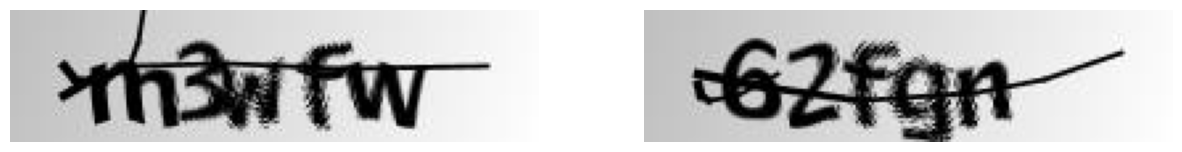

In [6]:
# access to images
images_png = glob.glob('./samples/*png')
images_jpg = glob.glob('./samples/*jpg')
print(f'PNG images count: {len(images_png)}')
print(f'JPG images count: {len(images_jpg)}')
# output images
array_0_png = cv2.imread(str(images_png[0]))
array_0_jpg = cv2.imread(str(images_jpg[0]))
plt.figure(figsize = (15,4))
plt.subplot(1,2,1)
plt.imshow(array_0_png)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(array_0_jpg)
plt.axis(False)
plt.show();

In [7]:
# define preprocessing class for image preparation and creating X and y arrays
class Preprocessing:
    def __init__(self):
        self.X = []
        self.y = []
    # method for image prepcoessing
    def image_preprocess(self, path):
# For every pixel, we apply same threshold value.If the pixel value is < threshold, it is set to 0, otherwise - max value
# It will remove the tinge from image
        img = cv2.imread(str(path), 0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
# We have some small holes in our image, it would be good if we close them
# Also this will remove the line on captcha images
        kernel = np.ones((5,5), np.uint8)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
# Increase white regions
        kernel = np.ones((2,2), np.uint8)
        img = cv2.dilate(img, kernel, iterations = 1)
# Adding blur for removing noise 
        img = cv2.GaussianBlur(img, (5,5), 0)
        return img
            
    # method for creating arrays for training
    def make_X_y(self):
        # for png files
        for img_path in images_png:
            img = self.image_preprocess(path = img_path)
            x = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
            for i in range(len(x)):
                self.X.append(Image.fromarray(x[i]))
                self.y.append(img_path[10:15][i]) # making labels
        # for jpg files
        for img_path in images_jpg:
            x = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
            for i in range(len(x)):
                self.X.append(Image.fromarray(x[i]))
                self.y.append(img_path[10:15][i])
        self.X = np.array(self.X) / 255 # normalizing
        return self.X, np.array(self.y)

X shape: (5345, 40, 20), y shape: (5345,)


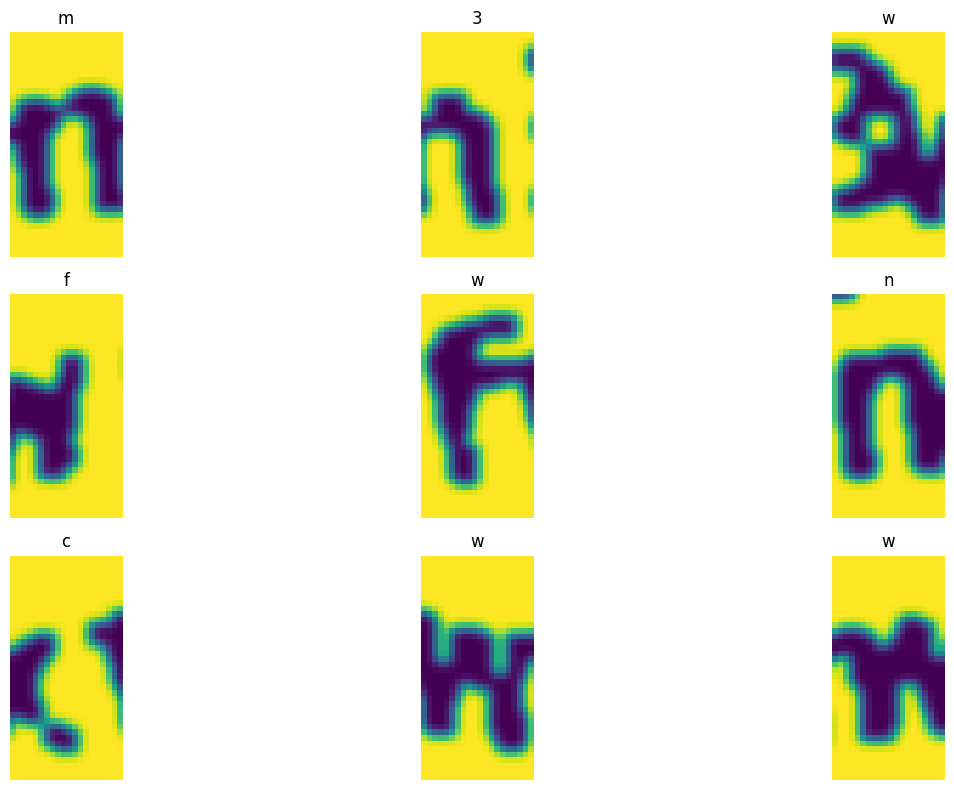

In [8]:
# creating arrays
prep = Preprocessing()
X, y = prep.make_X_y()
print(f'X shape: {X.shape}, y shape: {y.shape}')
# show new images of characters with corresponding labels
plt.figure(figsize = (15,8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.axis(False)
    plt.title(y[i])
plt.tight_layout()
plt.show();

In [9]:
# label encoding of y
y_enc = LabelEncoder().fit_transform(y)
# making y as one hot encoded vectors
y_hot = to_categorical(y_enc)
# creating train-test splits
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size = 0.2, random_state = 42)
# connecting label to corresponding captcha text
label_text = {y_enc[i]:y[i] for i in range(len(y))}
INPUT_SHAPE = (X.shape[1], X.shape[2], 1)

__Model Building.__

In [10]:
model = Sequential([
    Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = INPUT_SHAPE),
    MaxPool2D((2,2)),
    Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPool2D((2,2)),
    Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPool2D((2,2)),
    Conv2D(64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dropout(0.4),
    Dense(1500, activation = 'relu'),
    Dropout(0.3),
    Dense(700, activation = 'relu'),
    Dropout(0.3),
    Dense(400, activation = 'relu'),
    Dropout(0.2),
    Dense(y_hot.shape[1], activation = 'softmax'),
])

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = 'accuracy'
)

BATCH_SIZE = 200
EPOCHS = 300
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = EPOCHS, batch_size = BATCH_SIZE, shuffle = True)

2023-12-18 16:19:34.446249: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 16:19:34.476708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 16:19:34.476765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 16:19:34.479474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 16:19:34.479521: I tensorflow/compile

Epoch 1/300


2023-12-18 16:19:36.013441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-18 16:19:36.297448: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 16:19:36.805208: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 16:19:37.302176: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2dd40469b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 16:19:37.302219: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-12-18 16:19:37.310996: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-18 16:19:37.401049: I ./tensorflow/compiler/j

22/22 [==============================] - 5s 48ms/step - loss: 2.9239 - accuracy: 0.1038 - val_loss: 2.9243 - val_accuracy: 0.0758
Epoch 2/300
22/22 [==============================] - 0s 11ms/step - loss: 2.7511 - accuracy: 0.1293 - val_loss: 2.4262 - val_accuracy: 0.2535
Epoch 3/300
22/22 [==============================] - 0s 11ms/step - loss: 2.2023 - accuracy: 0.2858 - val_loss: 1.8051 - val_accuracy: 0.4911
Epoch 4/300
22/22 [==============================] - 0s 12ms/step - loss: 1.6987 - accuracy: 0.4766 - val_loss: 1.3290 - val_accuracy: 0.6211
Epoch 5/300
22/22 [==============================] - 0s 12ms/step - loss: 1.3248 - accuracy: 0.6043 - val_loss: 1.0295 - val_accuracy: 0.7138
Epoch 6/300
22/22 [==============================] - 0s 12ms/step - loss: 1.0808 - accuracy: 0.6918 - val_loss: 0.8600 - val_accuracy: 0.7530
Epoch 7/300
22/22 [==============================] - 0s 12ms/step - loss: 0.9423 - accuracy: 0.7259 - val_loss: 0.8022 - val_accuracy: 0.7605
Epoch 8/300
22/22 

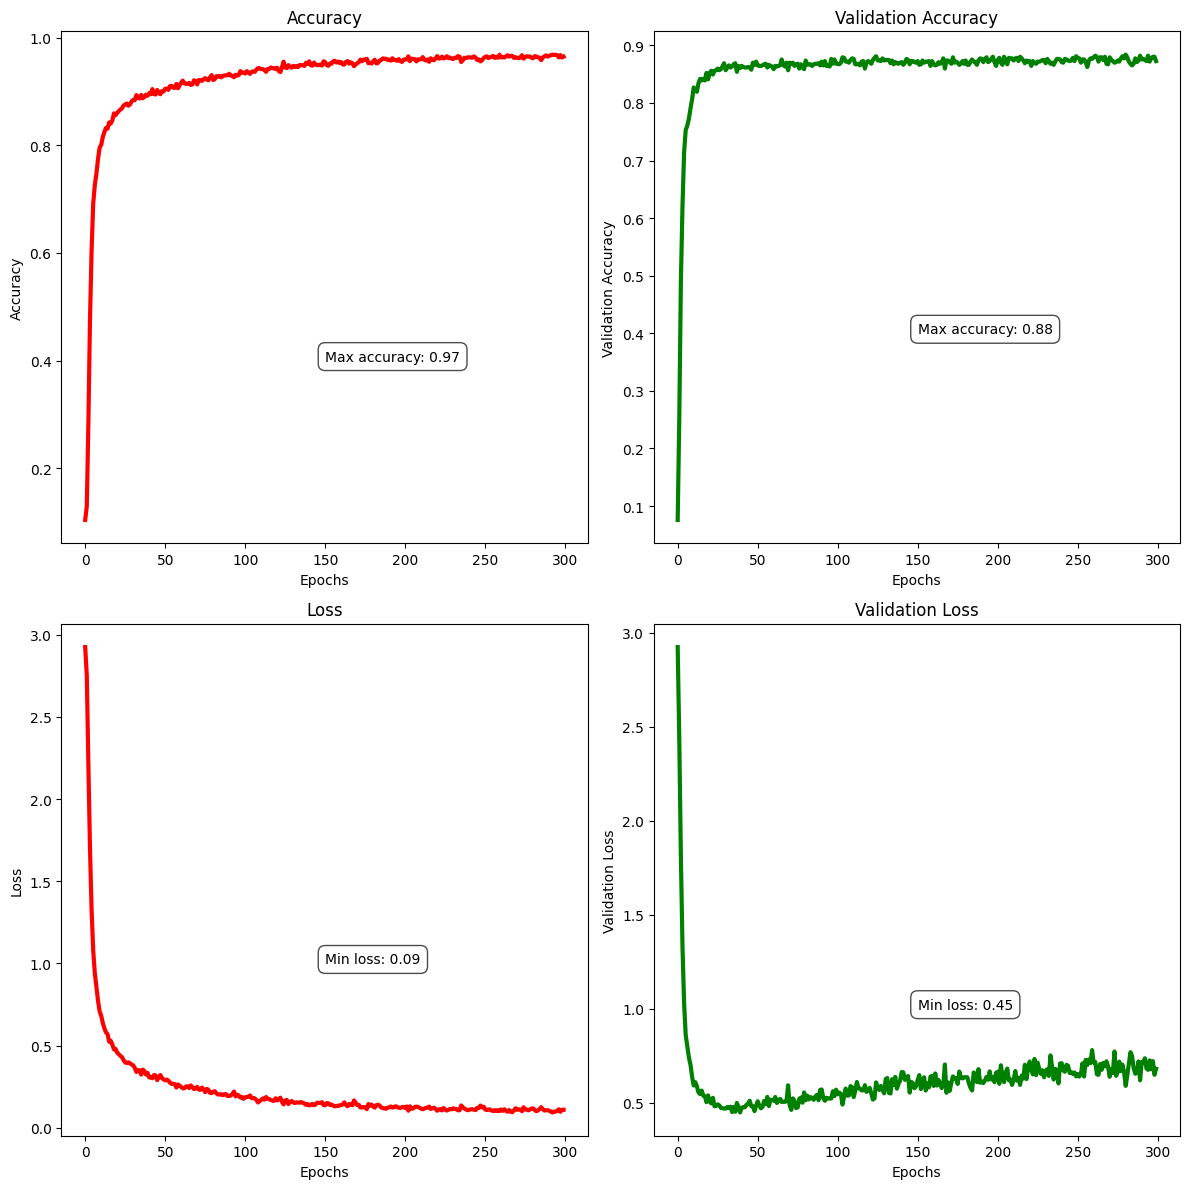

In [45]:
# plot loss and accuracy during training
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
plot_titles_list = ['Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss']
plot_topics_list = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
colors = ['red', 'green']
bbox = dict(facecolor = 'white', alpha = 0.7, boxstyle = 'round,pad=0.5')
for ax_i, title in enumerate(plot_titles_list):
    row = ax_i // 2
    col = ax_i % 2
    ax = axes[row, col]
    sns.lineplot(history.history[plot_topics_list[ax_i]], ax = ax, color = colors[ax_i % 2], lw = 3)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(plot_titles_list[ax_i])
    ax.set_title(plot_titles_list[ax_i])
    if ax_i == 0 or ax_i == 1:
        plot_text = f'Max accuracy: {round(np.max(history.history[plot_topics_list[ax_i]]), 2)}'
        ax.text(x = 150, y = 0.4, s = plot_text, bbox = bbox)
    elif ax_i == 2 or ax_i == 3:
        plot_text = f'Min loss: {round(np.min(history.history[plot_topics_list[ax_i]]), 2)}'
        ax.text(x = 150, y = 1, s = plot_text, bbox = bbox)
plt.tight_layout()
plt.show();

In [27]:
# define function for predicting
def predict_captcha(path_idx):
    img = Preprocessing().image_preprocess(images_png[path_idx])
    act_cap = images_png[path_idx][10:15]
    chars_img = [img[10:50, 30:50], img[10:50, 50:70], img[10:50, 70:90], img[10:50, 90:110], img[10:50, 110:130]]
    pred_cap = ''
    for i in range(5):
        pred_cap += label_text[np.argmax(model.predict(chars_img[i].reshape(1,40,20,1), verbose = 0))]
    return act_cap, pred_cap

# function for creating dataframe with real-predicted captchas
# predict in png paths because jpg files are only 30
def captcha_df(num_of_idx: int):
    cap_df = pd.DataFrame(columns = ['Real', 'Predicted'])
    for idx in range(num_of_idx):
        real_cap, pred_cap = predict_captcha(path_idx = idx)
        one_row = pd.DataFrame({'Real':[real_cap], 'Predicted':[pred_cap]})
        cap_df = pd.concat([cap_df, one_row], axis = 0, ignore_index = True)
    return cap_df

# function for show images and actual-predicted labels
def plot_act_pred(num_of_idx: int):
    plt.figure(figsize = (20,20))
    rows = 4
    cols = num_of_idx // rows if num_of_idx % rows == 0 else (num_of_idx // rows) + 1
    for i in range(num_of_idx):
        random_idx = np.random.randint(0, 1039)
        real_cap, pred_cap = predict_captcha(path_idx = random_idx)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.imread(str(images_png[random_idx])))
        plt.axis(False)
        plt.title(f'Real: {real_cap}\nPred: {pred_cap}')
    plt.tight_layout()
    plt.show();

In [46]:
png_pred = captcha_df(1039)
error_df = png_pred[png_pred['Real'] != png_pred['Predicted']]
print(f'Missclassifications count in PNG images: {error_df.shape[0]}')
display(error_df)

Missclassifications count in PNG images: 240


,Real,Predicted
5,678w3,678w2
10,c5xne,c5xme
13,65m85,65m4b
21,6m5eg,6n5e4
22,mmg2m,mmgfm
...,...,...
1013,mwdf6,mwnf6
1017,84w7x,84wfx
1018,2ycn8,2ycm8
1032,yfdn7,yfdb7


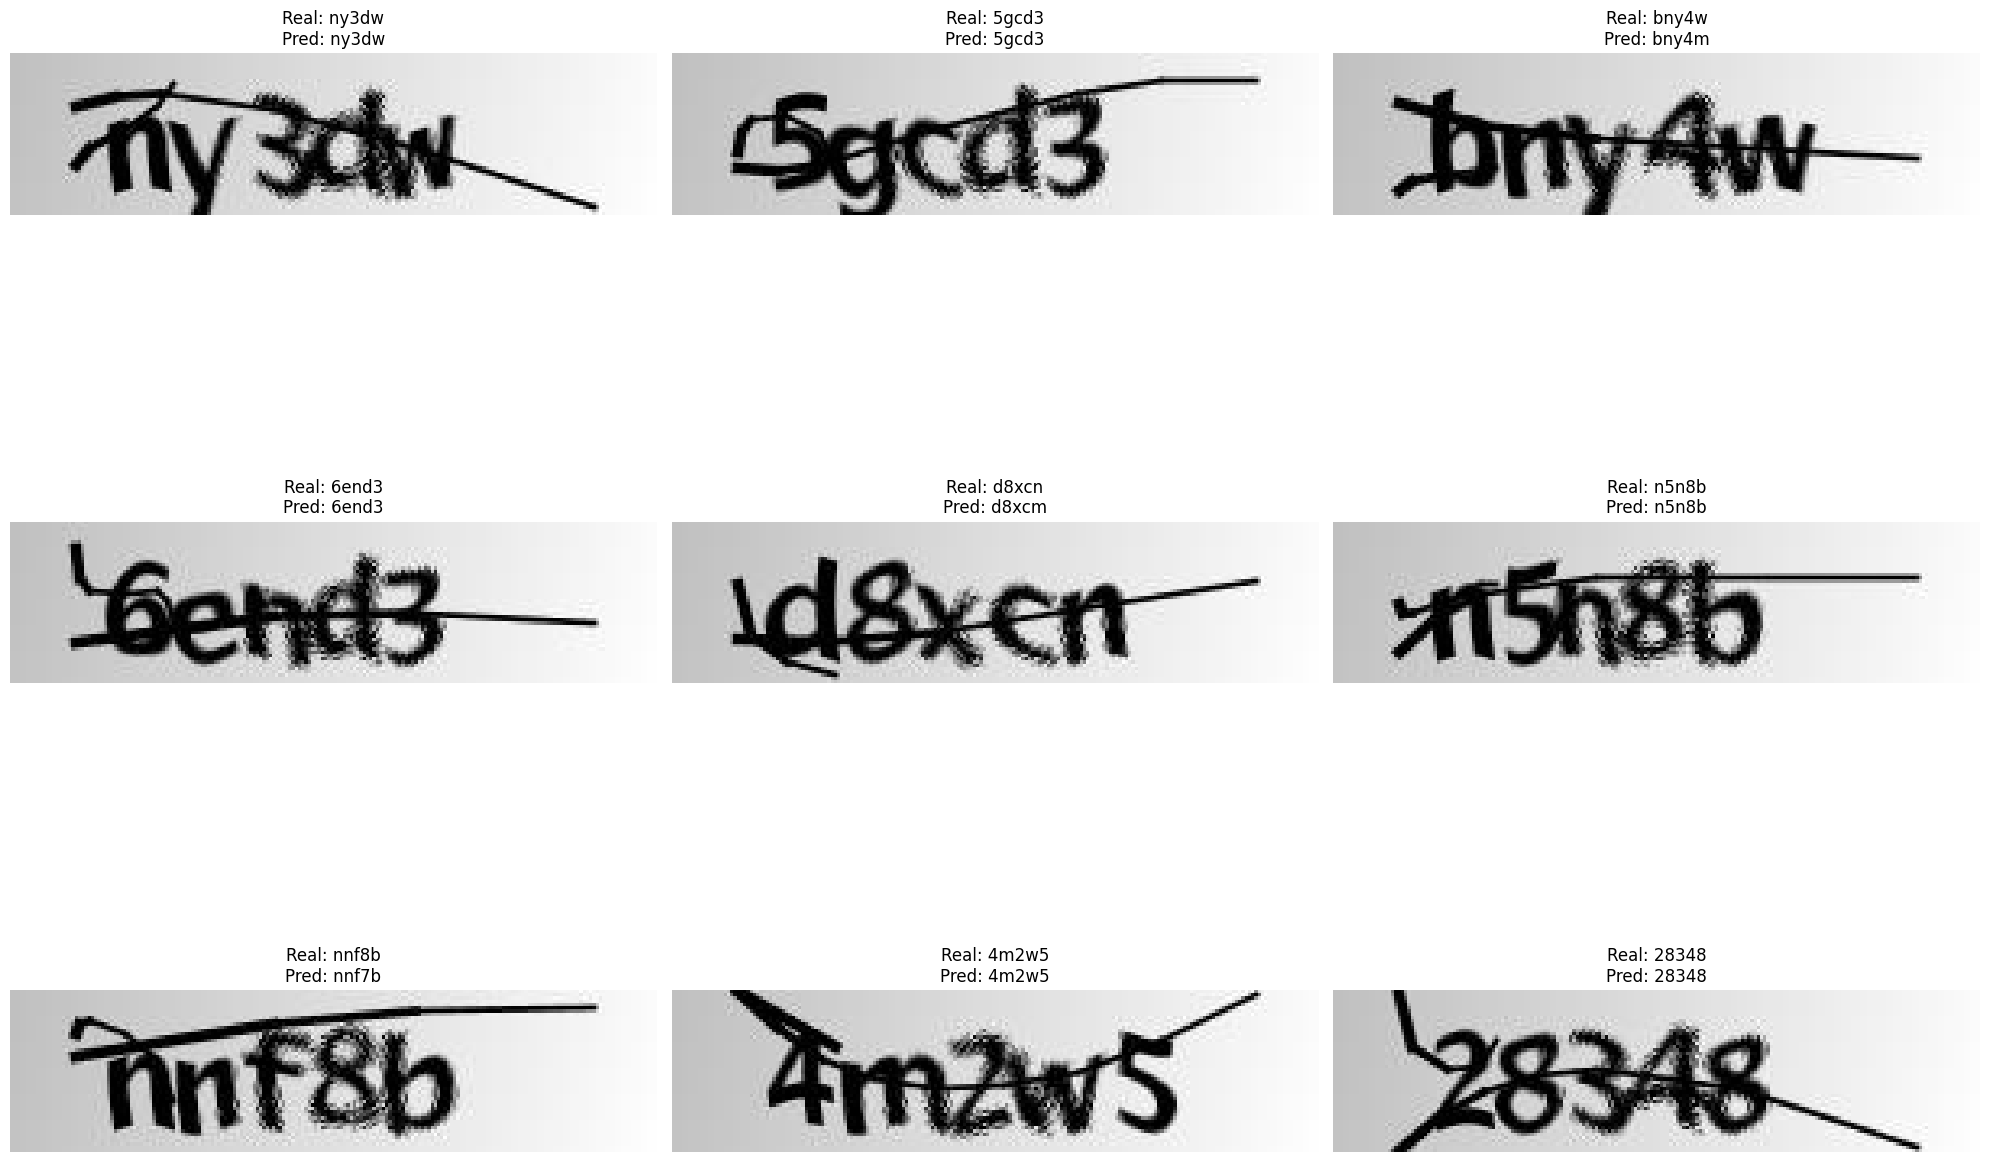

In [30]:
plot_act_pred(9)

In [ ]:
# model schema
keras.utils.plot_model(model, to_file = 'model_schema.png')